In [1]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

import gspread
from google.oauth2.service_account import Credentials

You are using wmfdata v1.0.3, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

FILE_D =  "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE_D, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)

# Data transformation

In [4]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,...,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2020-03-01,90443.0,2222674.0,21524.0,2802052.0,0.042328,2441182.0,5028.0,2955059.0,0.046599,702907.0,...,13262731.0,72189.0,0.054138,49822981.0,998024.0,20754272.0,244190247.0,53106575.0,60931896.0,81597749.0
2020-04-01,95994.0,2221239.0,23011.0,3374326.0,0.041195,2762677.0,5534.0,2023867.0,0.046041,825048.0,...,15206640.0,75388.0,0.053670,53021129.0,567161.0,22620119.0,248910247.0,53597875.0,61437796.0,85015749.0
2020-05-01,104508.0,2365101.0,25316.0,4189735.0,0.049743,2998223.0,6001.0,2392095.0,0.054792,778171.0,...,14663802.0,79734.0,0.060618,54751101.0,937664.0,25043268.0,253423126.0,53994249.0,62315999.0,87945231.0
2020-06-01,96014.0,2145261.0,23312.0,3417381.0,0.051572,2516055.0,5321.0,2117588.0,0.048071,813305.0,...,12869134.0,74680.0,0.057797,52960770.0,703996.0,25836962.0,255346022.0,54482157.0,62965617.0,88456686.0
2020-07-01,87691.0,2087988.0,23467.0,3133019.0,0.042145,2721998.0,5356.0,1496188.0,0.045204,799567.0,...,11996820.0,69031.0,0.066772,46233269.0,801286.0,21846294.0,257628665.0,54869438.0,63709358.0,89370427.0


In [5]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]


# Report

In [6]:
report_order = [
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
        'anonymous_edits',
        'non_anonymous_edits',
    #Editors
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'global_north_edits',
    'global_south_edits',
    #Diversity Editors
    'global_north_active_editors',
    'global_south_active_editors',
    'global_north_new_editor_retention',
    'global_south_new_editor_retention'

]

In [7]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        cagr = (ser[-1] / ser[-48])**(1/4) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, cagr]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change", "4_yr_cagr"]
    )

In [8]:
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

,value,yoy_change,4_yr_cagr
content_pages,"258,000,000",21.6%,18.0%
Wikipedia_articles,"54,900,000",7.4%,7.5%
Commons_content_pages,"63,700,000",14.7%,17.8%
Wikidata_entities,"89,400,000",51.3%,40.3%
net_new_content_pages,"2,280,000",3.0%,11.0%
net_new_Wikipedia_articles,"387,000",68.1%,3.6%
net_new_Commons_content_pages,"744,000",14.0%,16.0%
net_new_Wikidata_entities,"914,000",-14.1%,17.1%
revert_rate,6.7%,25.1%,-6.8%
total_edits,"46,200,000",20.9%,9.6%


# Graphs

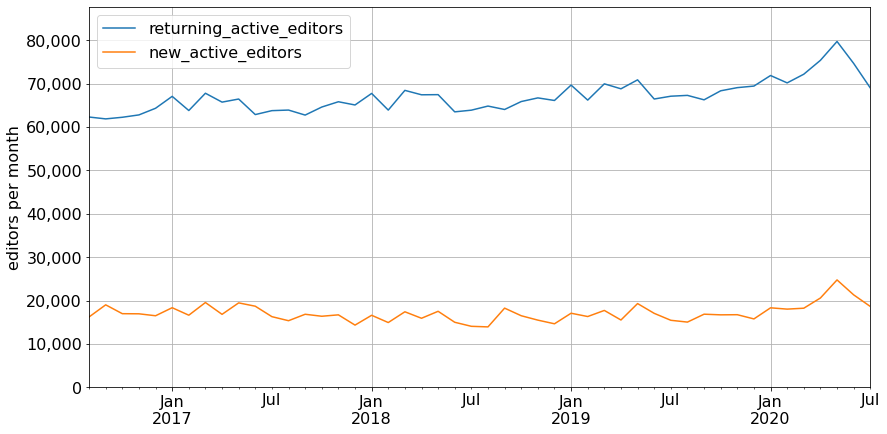

In [9]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

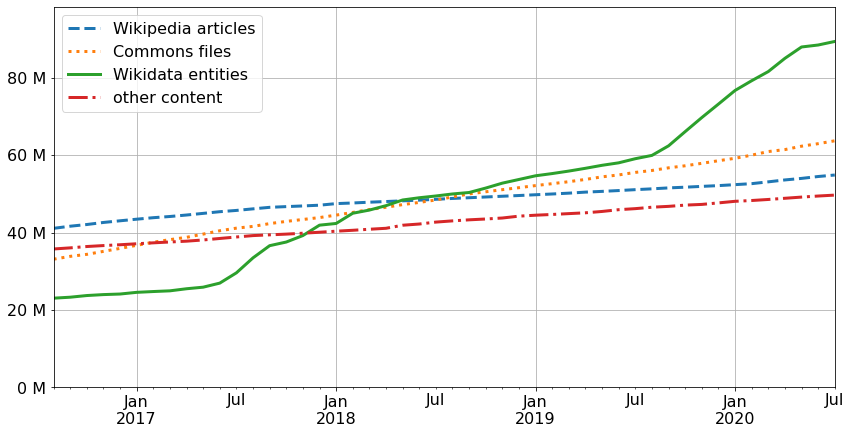

In [10]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

ax.yaxis.set_major_formatter(M_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");


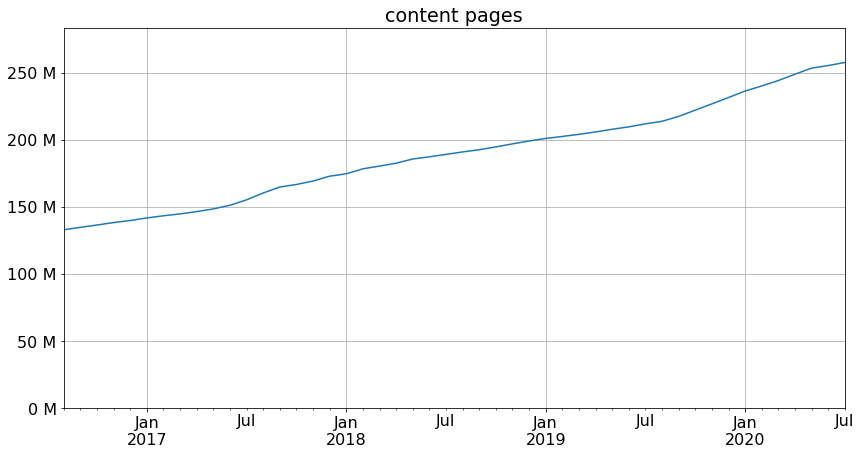

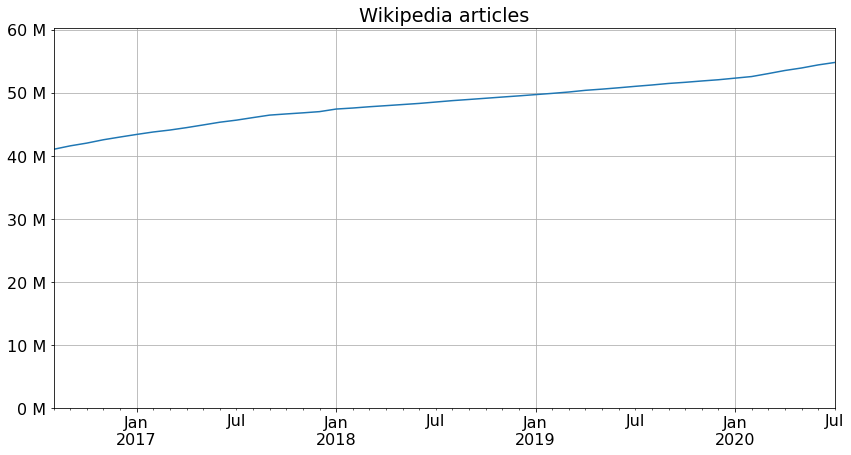

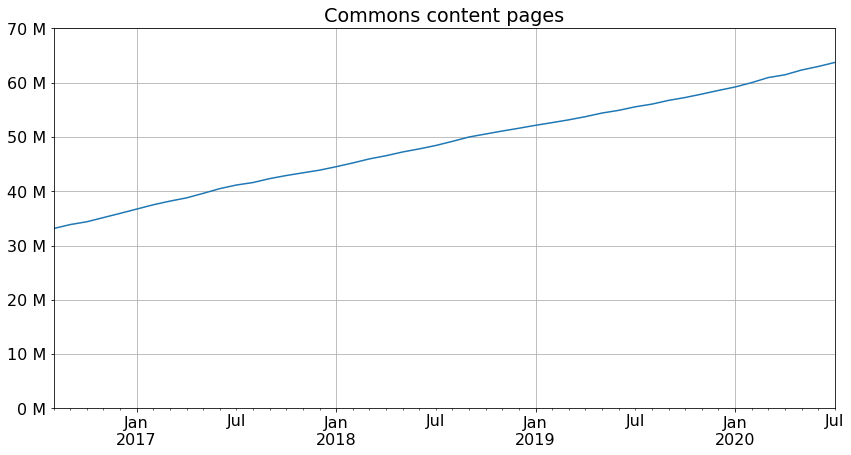

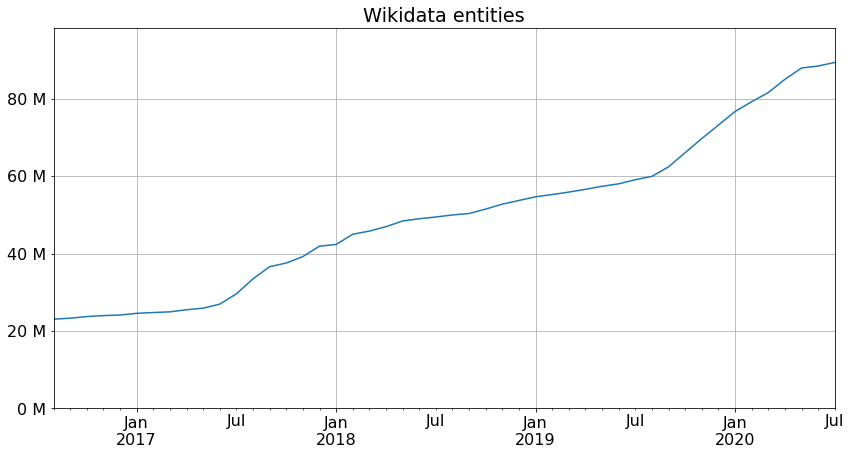

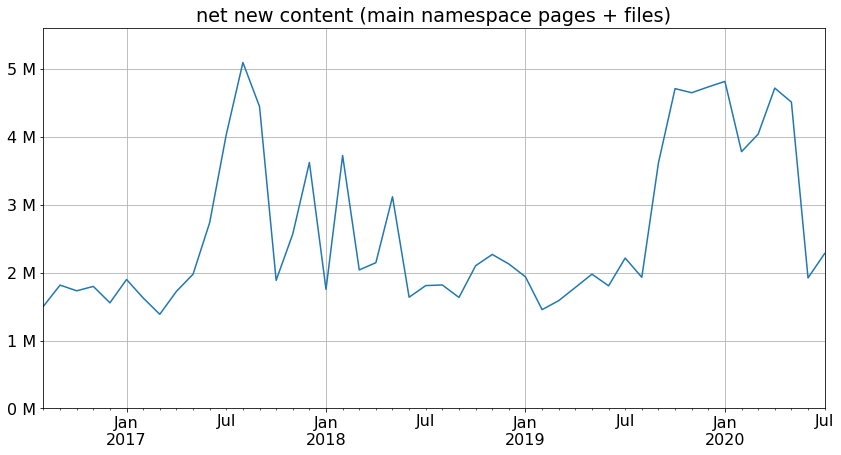

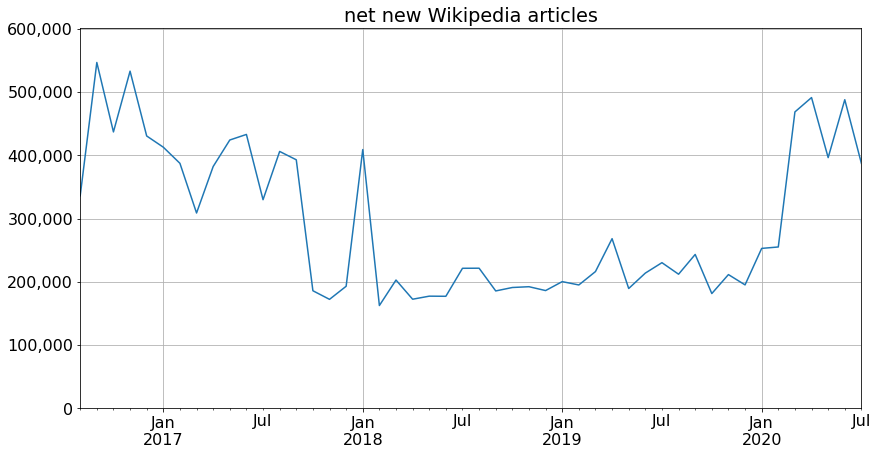

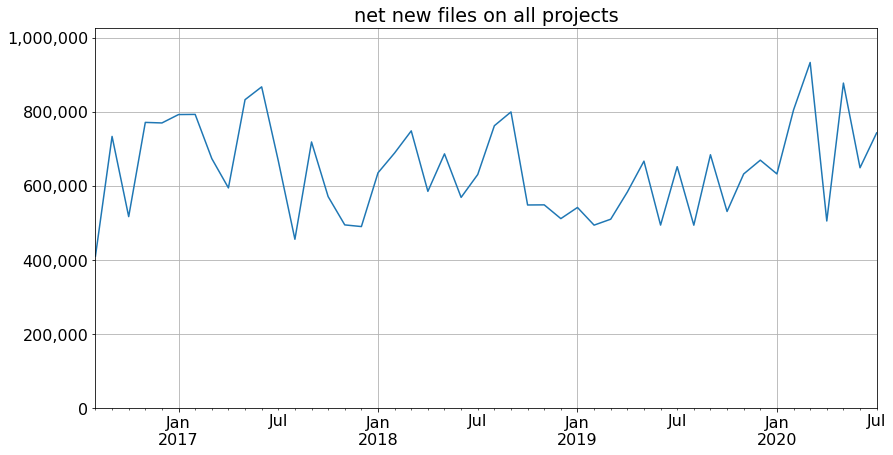

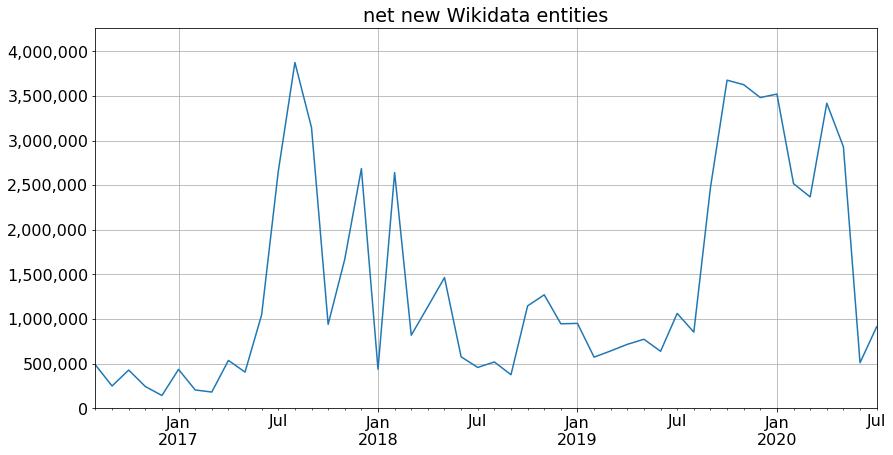

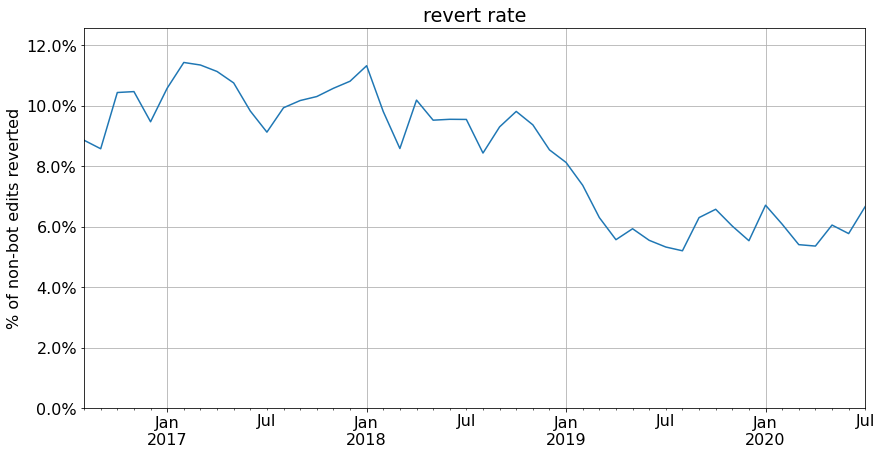

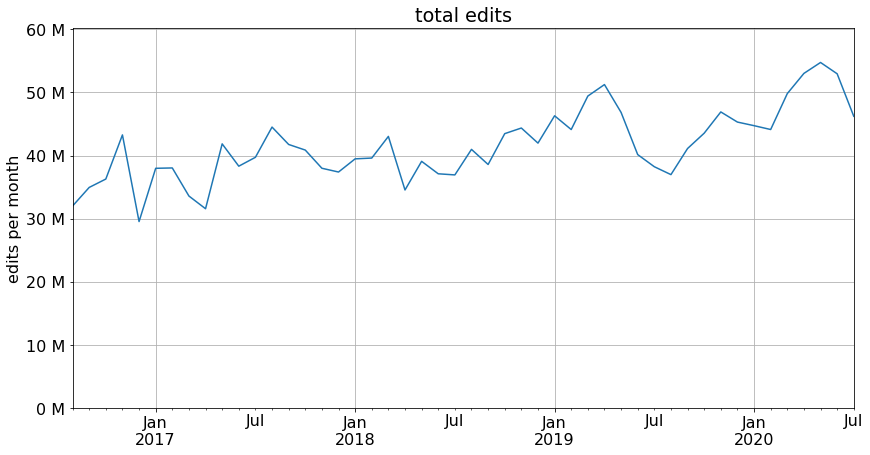

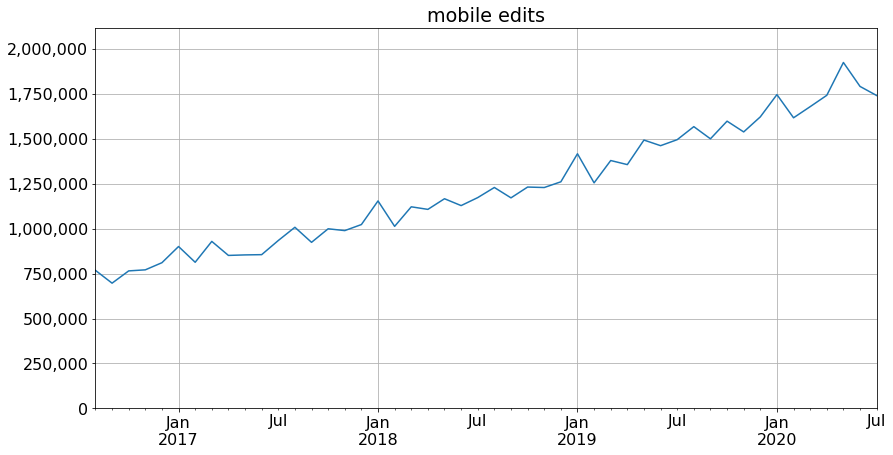

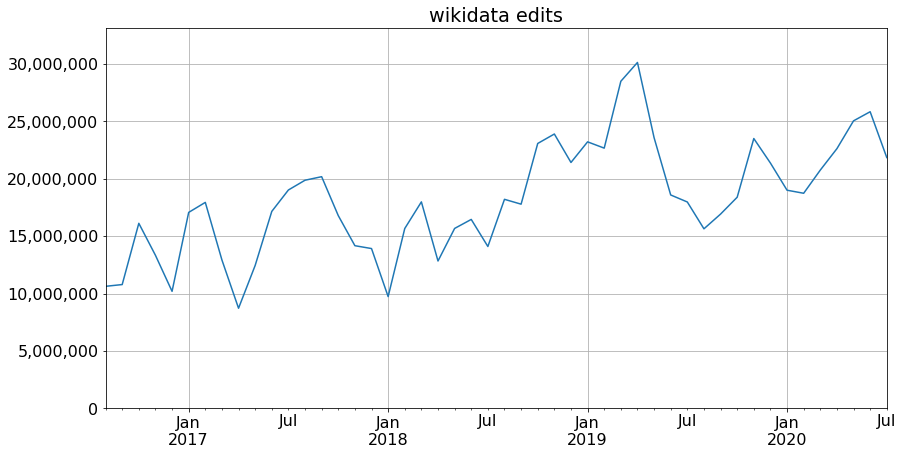

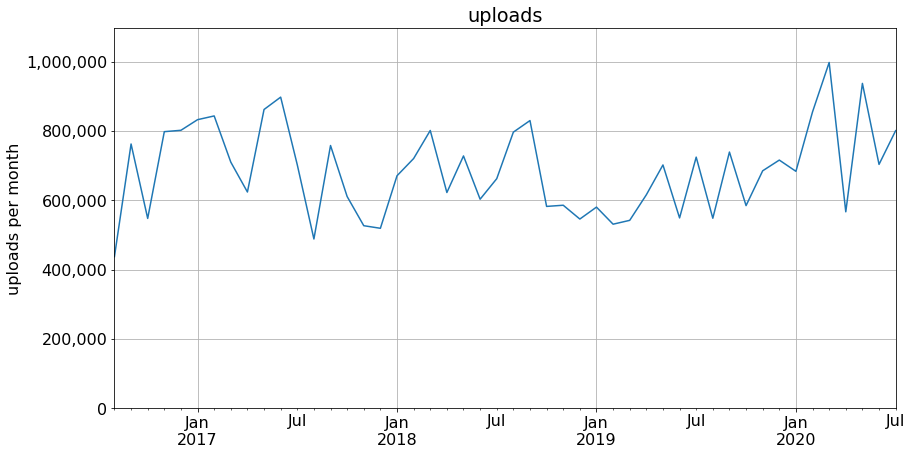

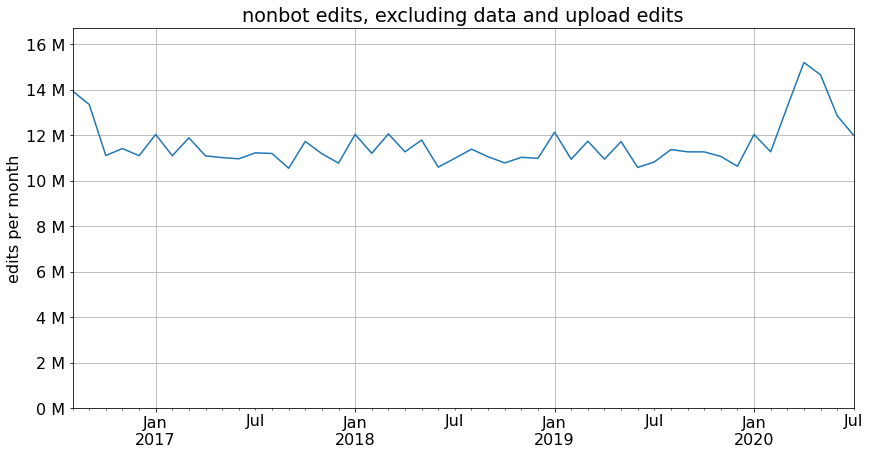

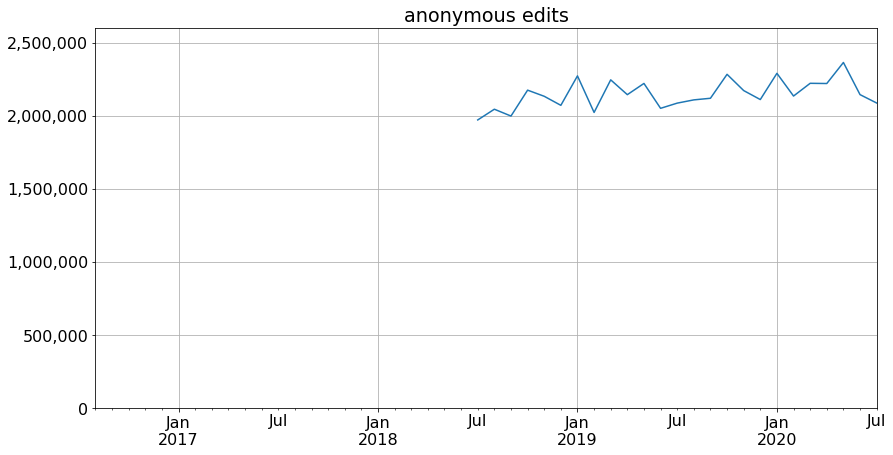

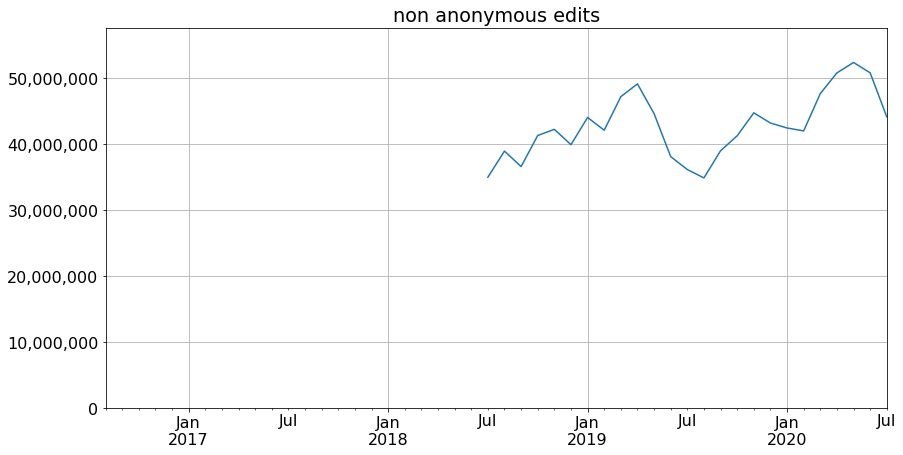

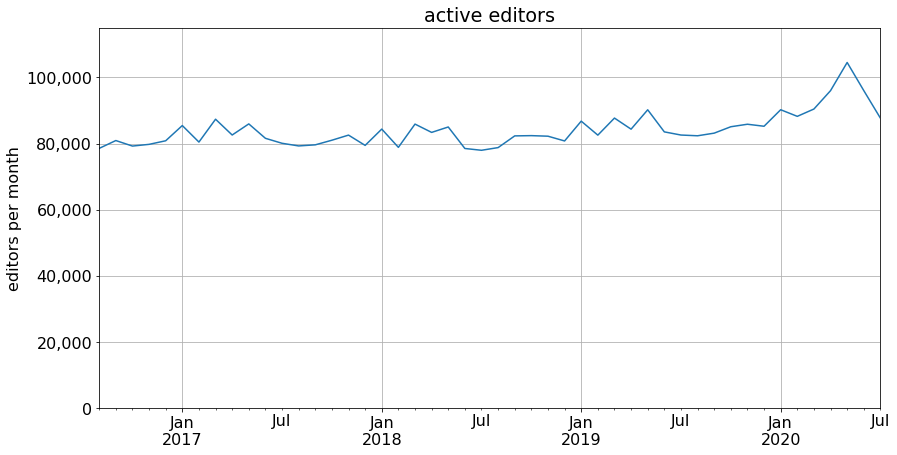

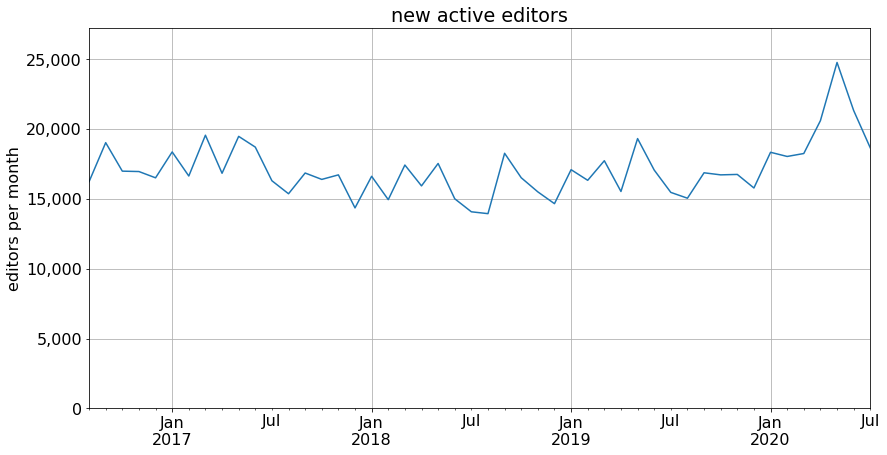

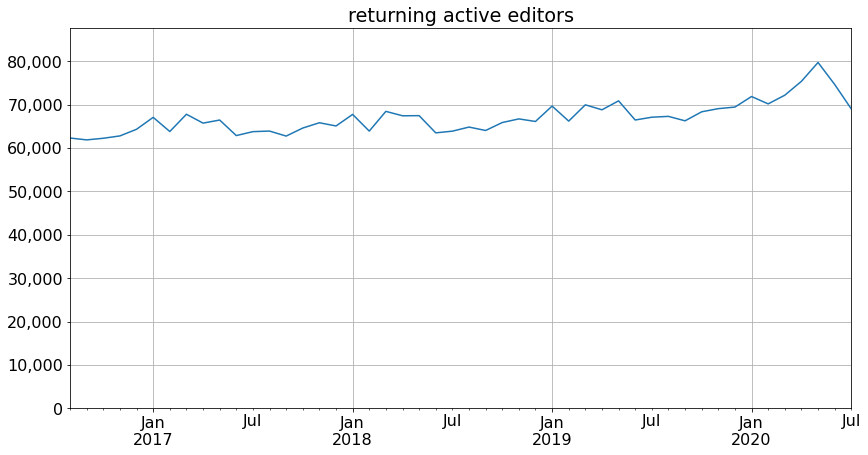

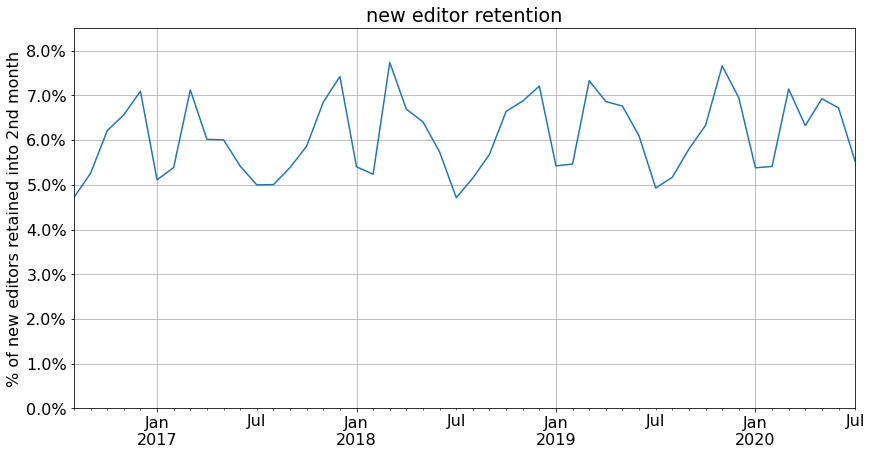

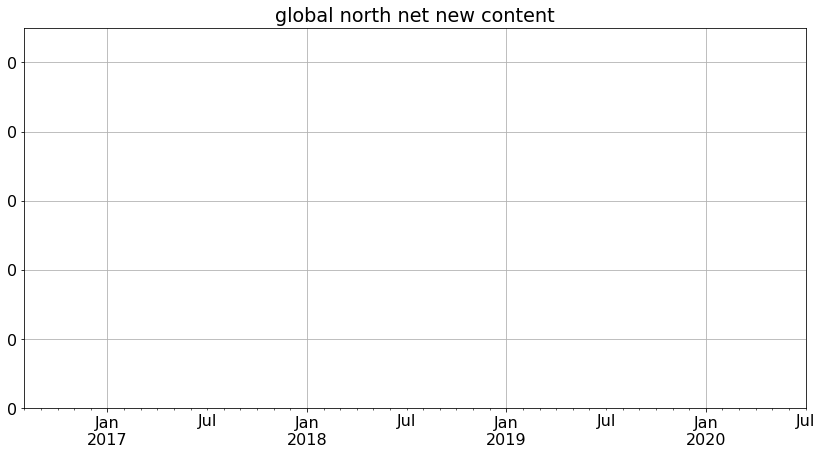

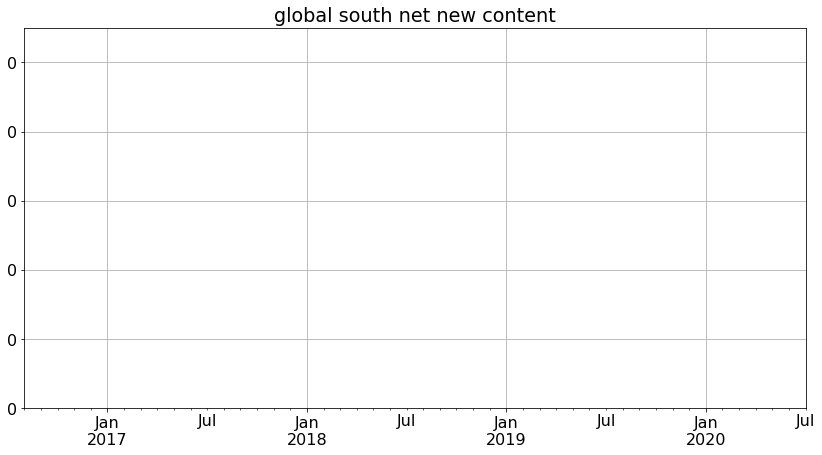

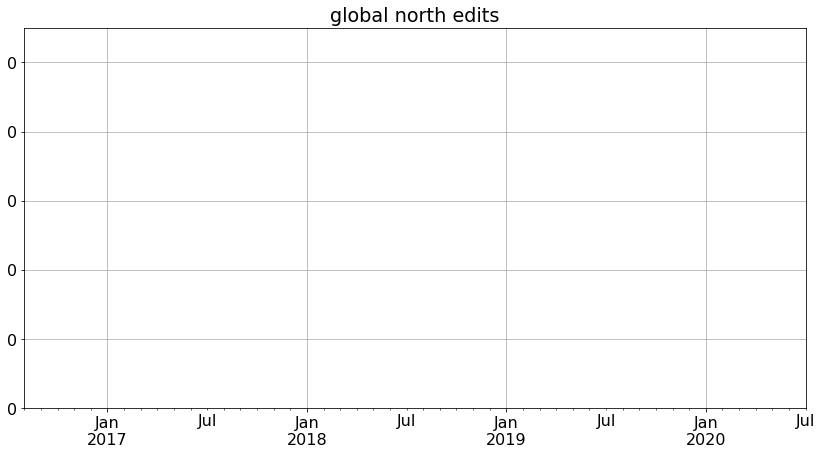

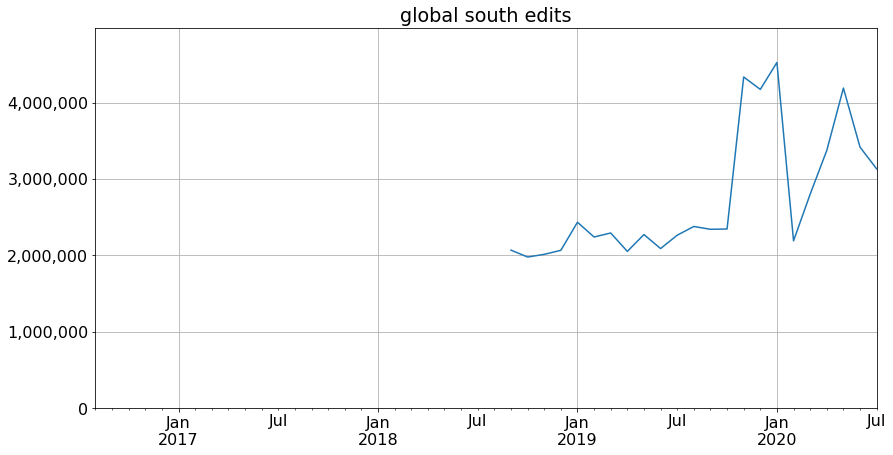

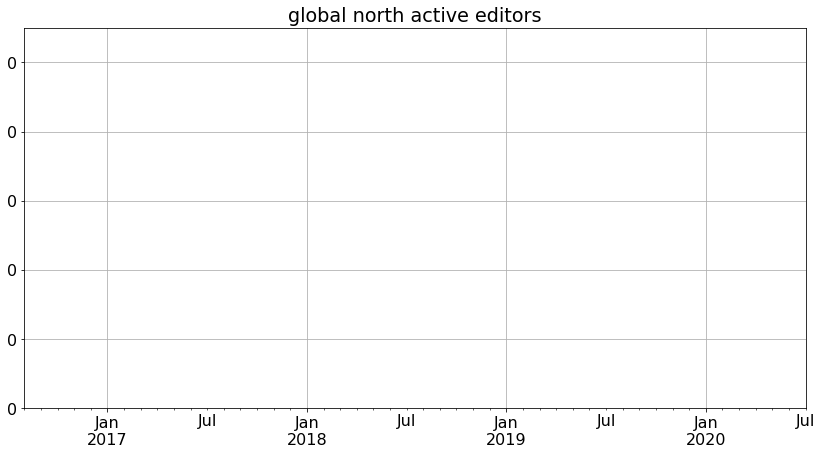

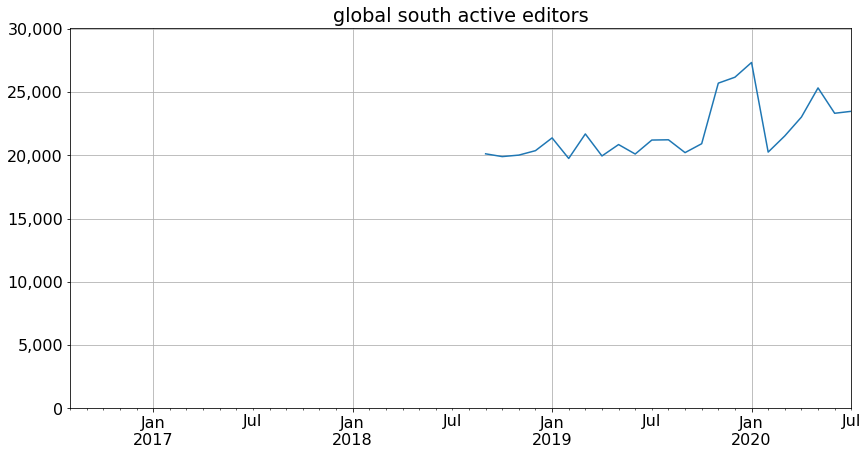

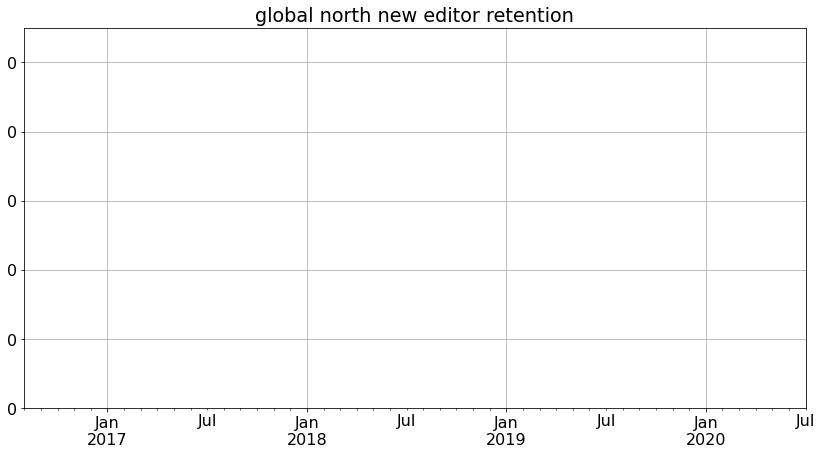

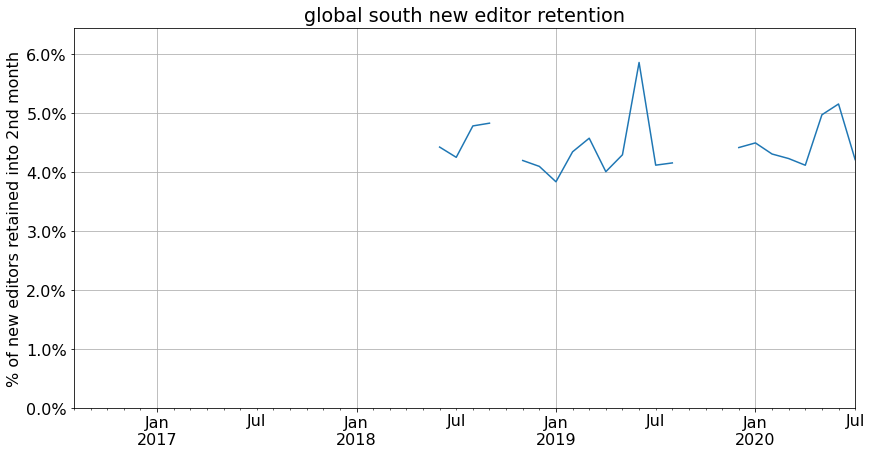

In [11]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
        "y_fmt": M_fmt,
    },
    "Wikipedia_articles": {
        "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
        "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
        "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
   
    "other_nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
        "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    },
    "global_south_new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    }
}

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()

# Update Google Sheet

In [12]:
FILE = "metrics/metrics.tsv"
all_metrics = pd.read_csv(FILE, sep="\t")


DIV_FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(DIV_FILE, sep="\t")


In [13]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('big-mender-274521-324384a764e2.json', scopes=scope)
gc = gspread.authorize(credentials)

In [14]:
all_metrics.iloc[-1,1:] = all_metrics.iloc[-1,1:].astype(float)
diversity_metrics.iloc[-1,1:] = diversity_metrics.iloc[-1,1:].astype(float)

In [15]:
@property
def sheet1(self):
    """Shortcut property for getting the first worksheet."""
    return self.get_worksheet(0)

In [20]:
wks1 = gc.open("editors").sheet1
new_metrics = all_metrics.iloc[-1,[0,1,12,13,14,15,16,17,19,20,21,22,23,24]].tolist()
wks1.append_row(new_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'metrics!A1:N237',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'metrics!A238:N238',
  'updatedRows': 1,
  'updatedColumns': 14,
  'updatedCells': 14}}

In [17]:
wks2 = gc.open("editors").get_worksheet(1)
div_metrics = diversity_metrics.iloc[-1].tolist()
wks2.append_row(div_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_global_market!A1:M31',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_global_market!A32:M32',
  'updatedRows': 1,
  'updatedColumns': 13,
  'updatedCells': 13}}

In [18]:
wks3 = gc.open("editors").get_worksheet(2)
mh_metrics = all_metrics.iloc[-1,[0,6,7,8,9]].tolist()
wks3.append_row(mh_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_mobile_heavy!A1:E236',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_mobile_heavy!A237:E237',
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}